<a href="https://colab.research.google.com/github/tayabba-19/Cricksheet-Match-Data-Analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Scraping Using Selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import os
import time

In [ ]:
# Navigating the driver to the website.

driver = webdriver.Chrome()
driver.get("https://cricsheet.org/matches/")

time.sleep(8) # Time for the website to fully load all the contents

In [ ]:
zip_links = driver.find_elements(By.XPATH, '//a[contains(@href, ".zip")]') # finds all the elements that are .zip files
download_urls = [link.get_attribute('href') for link in zip_links] # stores the links contained in the elements
print(f"Total JSON links found: {len(download_urls)}")





Sample JSON zip files URLs:
Total JSON links found: 86
https://cricsheet.org/downloads/all_json.zip
https://cricsheet.org/downloads/all.zip
https://cricsheet.org/downloads/tests_json.zip
https://cricsheet.org/downloads/tests.zip
https://cricsheet.org/downloads/mdms_json.zip
https://cricsheet.org/downloads/mdms.zip
https://cricsheet.org/downloads/odis_json.zip
https://cricsheet.org/downloads/odis.zip
https://cricsheet.org/downloads/odms_json.zip
https://cricsheet.org/downloads/odms.zip


In [ ]:
data = 'cricsheet_json_files'
os.makedirs(data, exist_ok=True) # creating a folder for the JSON zip files to be downloaded

required_matches = ['tests_json.zip', 'odis_json.zip', 't20s_json.zip', 'ipl_json.zip'] # The zip files we need to download
filtered_urls = []
for url in download_urls:
    file_name = url.split("/")[-1] # gives name of the zip file
    if file_name in required_matches:
        filtered_urls.append(url)

len_of_filtered_urls = len(filtered_urls)
print(f"Downloaded {len_of_filtered_urls} files into '{data}' folder.")
driver.quit()

Downloaded 4 files into 'cricsheet_json_files' folder.


In [ ]:
# this is for automating the downloading & storing part:

for url in filtered_urls:
    file_name = url.split("/")[-1]
    full_path = os.path.join(data, file_name)

    # Only download if the .zip file doesn't exist already
    if not os.path.exists(full_path):
        response = requests.get(url)
        with open(full_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {file_name}")
    else:
        print(f"Already exists: {file_name}")


Already exists: tests_json.zip
Already exists: odis_json.zip
Already exists: t20s_json.zip
Already exists: ipl_json.zip


# 2. Data Transformation

In [ ]:
import zipfile

extract_folder = 'extracted_matches'
os.makedirs(extract_folder,exist_ok = True)

for file in os.listdir("cricsheet_json_files"):
    if file.endswith(".zip"):
        zip_path = os.path.join("cricsheet_json_files", file)
        match_type = file.replace("_json.zip", "")
        output_path = os.path.join(extract_folder,match_type)
        os.makedirs(output_path, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_path)
        print(f"Extracted: {file} to {output_path}")



Extracted: ipl_json.zip to extracted_matches\ipl
Extracted: odis_json.zip to extracted_matches\odis
Extracted: t20s_json.zip to extracted_matches\t20s
Extracted: tests_json.zip to extracted_matches\tests


In [ ]:
import pandas as pd
import json
import os

def parse_ball_by_ball(folder_path, match_type_label):
    """
    Parses all JSON files in a folder and returns a ball-by-ball dataframe
    with batter, bowler, runs, wickets, and other delivery info.
    """
    delivery_data = []

    for file in os.listdir(folder_path):
        if file.endswith(".json"):
            filepath = os.path.join(folder_path, file)

            with open(filepath, "r") as f:
                match = json.load(f)

            info = match.get("info", {})
            match_date = info.get("dates", [""])[0]
            teams = info.get("teams", ["", ""])
            innings = match.get("innings", [])

            for inning_index, inning in enumerate(innings, start=1):
                batting_team = inning.get("team", "")
                overs = inning.get("overs", [])

                for over_data in overs:
                    over_number = over_data.get("over", -1)
                    deliveries = over_data.get("deliveries", [])

                    for ball_number, delivery in enumerate(deliveries, start=1):
                        batter = delivery.get("batter", "")
                        bowler = delivery.get("bowler", "")
                        non_striker = delivery.get("non_striker", "")

                        runs_batter = delivery.get("runs", {}).get("batter", 0)
                        runs_extras = delivery.get("runs", {}).get("extras", 0)
                        total_runs = delivery.get("runs", {}).get("total", 0)

                        dismissal_kind = None
                        player_out = None

                        if "wickets" in delivery:
                            for w in delivery["wickets"]:
                                dismissal_kind = w.get("kind", "")
                                player_out = w.get("player_out", "")

                        delivery_data.append({
                            "match_type": match_type_label,
                            "date": match_date,
                            "inning": inning_index,
                            "over": over_number,
                            "ball": ball_number,
                            "team": batting_team,
                            "batter": batter,
                            "bowler": bowler,
                            "non_striker": non_striker,
                            "runs_batter": runs_batter,
                            "runs_extras": runs_extras,
                            "total_runs": total_runs,
                            "dismissal_kind": dismissal_kind,
                            "player_out": player_out
                        })

    return pd.DataFrame(delivery_data)


In [ ]:
test_path = os.path.join(extract_folder, "tests")
odi_path = os.path.join(extract_folder, "odis")
t20_path = os.path.join(extract_folder, "t20s")
ipl_path = os.path.join(extract_folder, "ipl")

df_test = parse_ball_by_ball(test_path, "Test")
df_odi = parse_ball_by_ball(odi_path, "ODI")
df_t20 = parse_ball_by_ball(t20_path, "T20")
df_ipl = parse_ball_by_ball(ipl_path, "IPL")


In [ ]:
df_test.head()

,match_type,date,inning,over,ball,team,batter,bowler,non_striker,runs_batter,runs_extras,total_runs,dismissal_kind,player_out
0,Test,2016-11-03,1,0,1,South Africa,SC Cook,MA Starc,D Elgar,0,0,0,None,None
1,Test,2016-11-03,1,0,2,South Africa,SC Cook,MA Starc,D Elgar,0,0,0,None,None
2,Test,2016-11-03,1,0,3,South Africa,SC Cook,MA Starc,D Elgar,0,0,0,None,None
3,Test,2016-11-03,1,0,4,South Africa,SC Cook,MA Starc,D Elgar,0,0,0,caught,SC Cook
4,Test,2016-11-03,1,0,5,South Africa,HM Amla,MA Starc,D Elgar,0,0,0,None,None


In [ ]:
df_odi.head()

,match_type,date,inning,over,ball,team,batter,bowler,non_striker,runs_batter,runs_extras,total_runs,dismissal_kind,player_out
0,ODI,2017-01-13,1,0,1,Australia,DA Warner,Mohammad Amir,TM Head,0,0,0,None,None
1,ODI,2017-01-13,1,0,2,Australia,DA Warner,Mohammad Amir,TM Head,0,0,0,None,None
2,ODI,2017-01-13,1,0,3,Australia,DA Warner,Mohammad Amir,TM Head,0,0,0,None,None
3,ODI,2017-01-13,1,0,4,Australia,DA Warner,Mohammad Amir,TM Head,0,0,0,None,None
4,ODI,2017-01-13,1,0,5,Australia,DA Warner,Mohammad Amir,TM Head,0,1,1,None,None


In [ ]:
df_t20.head()

,match_type,date,inning,over,ball,team,batter,bowler,non_striker,runs_batter,runs_extras,total_runs,dismissal_kind,player_out
0,T20,2017-02-17,1,0,1,Australia,AJ Finch,SL Malinga,M Klinger,0,0,0,None,None
1,T20,2017-02-17,1,0,2,Australia,AJ Finch,SL Malinga,M Klinger,0,0,0,None,None
2,T20,2017-02-17,1,0,3,Australia,AJ Finch,SL Malinga,M Klinger,1,0,1,None,None
3,T20,2017-02-17,1,0,4,Australia,M Klinger,SL Malinga,AJ Finch,2,0,2,None,None
4,T20,2017-02-17,1,0,5,Australia,M Klinger,SL Malinga,AJ Finch,0,0,0,None,None


In [ ]:
df_ipl.head()

,match_type,date,inning,over,ball,team,batter,bowler,non_striker,runs_batter,runs_extras,total_runs,dismissal_kind,player_out
0,IPL,2017-04-05,1,0,1,Sunrisers Hyderabad,DA Warner,TS Mills,S Dhawan,0,0,0,None,None
1,IPL,2017-04-05,1,0,2,Sunrisers Hyderabad,DA Warner,TS Mills,S Dhawan,0,0,0,None,None
2,IPL,2017-04-05,1,0,3,Sunrisers Hyderabad,DA Warner,TS Mills,S Dhawan,4,0,4,None,None
3,IPL,2017-04-05,1,0,4,Sunrisers Hyderabad,DA Warner,TS Mills,S Dhawan,0,0,0,None,None
4,IPL,2017-04-05,1,0,5,Sunrisers Hyderabad,DA Warner,TS Mills,S Dhawan,0,2,2,None,None


# 3. Database Management

In [ ]:
import sqlite3

# connecting to the SQLite database using connector

conn = sqlite3.connect("cricsheet_analysis.db")
cursor = conn.cursor()


In [ ]:
# Save each dataframe to a table in SQLite
df_test.to_sql("test_matches", conn, if_exists="replace", index=False)
df_odi.to_sql("odi_matches", conn, if_exists="replace", index=False)
df_t20.to_sql("t20_matches", conn, if_exists="replace", index=False)
df_ipl.to_sql("ipl_matches", conn, if_exists="replace", index=False)

print("All data inserted successfully into SQLite")

All data inserted successfully into SQLite


# 4. SQL Queries for Data Analysis & 5. EDA using Python

### query1: Te top 10 batsmen by total runs in ODI matches:


In [ ]:

query = """
SELECT batter, SUM(runs_batter) AS total_runs
FROM odi_matches
GROUP BY batter
ORDER BY total_runs DESC
LIMIT 10;
"""

df_result = pd.read_sql_query(query, conn)
df_result

,batter,total_runs
0,V Kohli,14059
1,KC Sangakkara,11618
2,RG Sharma,10948
3,MS Dhoni,10274
4,AB de Villiers,9435
5,TM Dilshan,9212
6,LRPL Taylor,8126
7,DPMD Jayawardene,8040
8,HM Amla,7834
9,Tamim Iqbal,7648


### query2: the top 10 bowlers who took the most wickets in T20 matches


In [ ]:

query2 = """

SELECT
bowler,
COUNT(*) AS wickets
FROM t20_matches
WHERE dismissal_kind IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;

"""

df2_result = pd.read_sql_query(query2, conn)
df2_result

,bowler,wickets
0,TG Southee,175
1,ML Schutt,161
2,DB Sharma,148
3,IS Sodhi,146
4,S Ecclestone,144
5,Shakib Al Hasan,138
6,Mustafizur Rahman,137
7,AU Rashid,137
8,Nida Dar,134
9,Ehsan Khan,134


### query 3: Team with the highest win percentage in Test cricket


In [ ]:

# for this, we write a new function which gives the summary of the matches.

def matchSummary(folder_path, match_type_label):
    summary_data = []

    for file in os.listdir(folder_path):
        if file.endswith(".json"):
            filepath = os.path.join(folder_path, file)
            with open(filepath, "r") as f:
                match = json.load(f)

            info = match.get("info", {})
            date = info.get("dates", [""])[0]
            venue = info.get("venue", "")
            teams = info.get("teams", ["", ""])
            winner = info.get("outcome", {}).get("winner", "Draw/No result")
            toss_winner = info.get("toss", {}).get("winner", "")
            toss_decision = info.get("toss", {}).get("decision", "")
            outcome_by = info.get("outcome", {}).get("by", {})

            if "runs" in outcome_by:
                margin = outcome_by["runs"]
                margin_type = "runs"
            elif "wickets" in outcome_by:
                margin = outcome_by["wickets"]
                margin_type = "wickets"
            else:
                margin = None
                margin_type = None


            summary_data.append({
                "match_type": match_type_label,
                "date": date,
                "venue": venue,
                "team1": teams[0],
                "team2": teams[1],
                "winner": winner,
                "toss_winner": toss_winner,
                "toss_decision": toss_decision,
                "margin": margin,
                "margin_type": margin_type
            })

    return pd.DataFrame(summary_data)

test_summary_df = matchSummary(test_path,"tests")

test_summary_df.to_sql("test_summary", conn, if_exists="replace", index=False)


869

In [ ]:

query3 = """
SELECT
    played.team,
    played.matches_played,
    won.matches_won,
    ROUND(won.matches_won * 100.0 / played.matches_played, 2) AS win_percentage
FROM
    (
        SELECT team, COUNT(*) AS matches_played
        FROM (
            SELECT team1 AS team FROM test_summary
            UNION ALL
            SELECT team2 AS team FROM test_summary
        ) AS all_teams
        GROUP BY team
    ) AS played
LEFT JOIN
    (
        SELECT winner AS team, COUNT(*) AS matches_won
        FROM test_summary
        WHERE winner IS NOT NULL
        GROUP BY winner
    ) AS won
ON played.team = won.team
ORDER BY win_percentage DESC;
"""
df3_result = pd.read_sql_query(query3, conn)
df3_result


,team,matches_played,matches_won,win_percentage
0,Australia,232,127.0,54.74
1,South Africa,190,95.0,50.00
2,India,216,104.0,48.15
3,England,277,119.0,42.96
4,New Zealand,160,63.0,39.38
5,Sri Lanka,174,67.0,38.51
6,Pakistan,155,55.0,35.48
7,Ireland,8,2.0,25.00
8,West Indies,162,37.0,22.84
9,Bangladesh,118,21.0,17.80


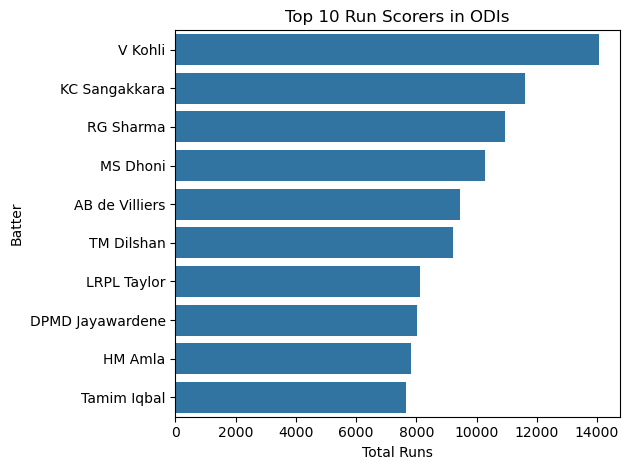

In [ ]:
sns.barplot(data=df_result, y="batter", x="total_runs")
plt.title("Top 10 Run Scorers in ODIs")
plt.xlabel("Total Runs")
plt.ylabel("Batter")
plt.tight_layout()
plt.show()


### query4: Total number of centuries across all match types.

In [ ]:

query4 = """
SELECT COUNT(*) AS total_centuries
FROM (
    SELECT batter, date, SUM(runs_batter) AS total_runs
    FROM (
        SELECT batter, date, runs_batter FROM test_matches
        UNION ALL
        SELECT batter, date, runs_batter FROM odi_matches
        UNION ALL
        SELECT batter, date, runs_batter FROM t20_matches
        UNION ALL
        SELECT batter, date, runs_batter FROM ipl_matches
    ) AS all_data
    GROUP BY batter, date
    HAVING total_runs >= 100
) AS century_list;
"""

df4_result = pd.read_sql_query(query4, conn)
df4_result


,total_centuries
0,4342


### query5: Matches with the narrowest margin of victory.

In [ ]:
df_test_summary = matchSummary(test_path,"tests")
df_odi_summary = matchSummary(odi_path,"odis")
df_t20_summary = matchSummary(t20_path,"t20s")
df_ipl_summary = matchSummary(ipl_path,"ipl")

df_match_summary = pd.concat([df_test_summary, df_odi_summary, df_t20_summary, df_ipl_summary])
df_match_summary.to_sql("match_summary", conn, if_exists="replace", index=False)


query5 = """
SELECT *
FROM match_summary
WHERE margin IS NOT NULL
ORDER BY margin ASC
LIMIT 5;
"""

df_result5 = pd.read_sql_query(query5, conn)
df_result5

,match_type,date,venue,team1,team2,winner,toss_winner,toss_decision,margin,margin_type
0,tests,2019-02-13,Kingsmead,South Africa,Sri Lanka,Sri Lanka,Sri Lanka,field,1.0,wickets
1,tests,2019-08-22,Headingley,England,Australia,England,England,field,1.0,wickets
2,tests,2021-08-12,"Sabina Park, Kingston, Jamaica",Pakistan,West Indies,West Indies,West Indies,field,1.0,wickets
3,tests,2023-02-24,"Basin Reserve, Wellington",England,New Zealand,New Zealand,New Zealand,field,1.0,runs
4,tests,2006-08-04,P Sara Oval,South Africa,Sri Lanka,Sri Lanka,South Africa,bat,1.0,wickets


### query6: total matches in each match types(ipl,test,t20,odi)

In [ ]:

query6 = """
SELECT match_type, COUNT(*) AS total_matches
FROM match_summary
GROUP BY match_type;
"""
df_result6 = pd.read_sql_query(query6, conn)
df_result6

,match_type,total_matches
0,ipl,1169
1,odis,2980
2,t20s,4342
3,tests,869


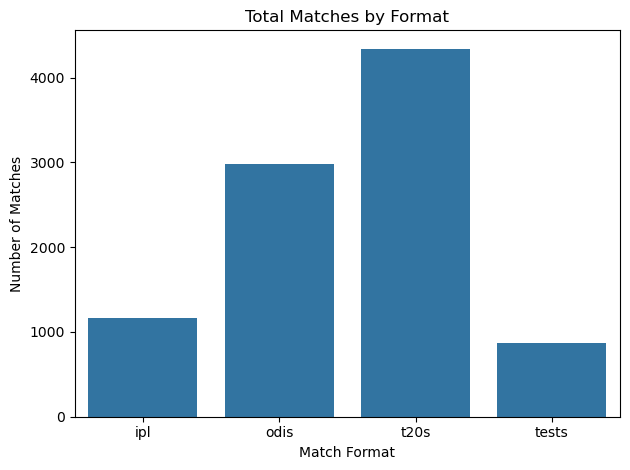

In [ ]:
sns.barplot(data=df_result6, x="match_type", y="total_matches")
plt.title("Total Matches by Format")
plt.xlabel("Match Format")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()


### query7: Toss decision frequency

In [ ]:

query7 = """
SELECT match_type, toss_decision, COUNT(*) AS decision_count
FROM match_summary
GROUP BY match_type, toss_decision
ORDER BY match_type, decision_count DESC;

"""
df_result7 = pd.read_sql_query(query7, conn)
df_result7

,match_type,toss_decision,decision_count
0,ipl,field,764
1,ipl,bat,405
2,odis,field,1512
3,odis,bat,1468
4,t20s,field,2294
5,t20s,bat,2048
6,tests,bat,595
7,tests,field,274


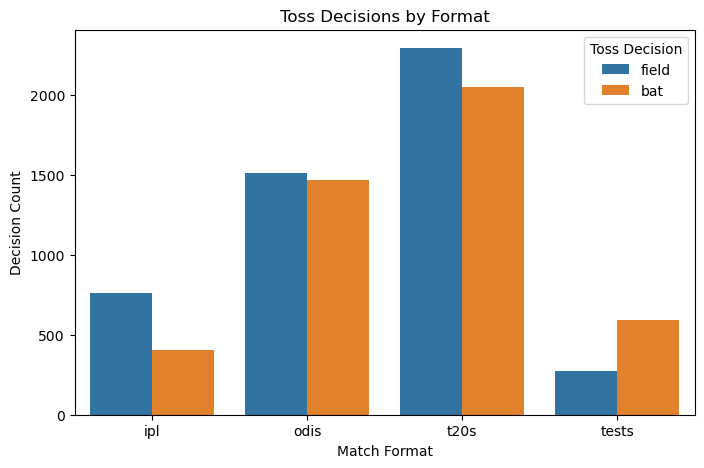

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_result7, x="match_type", y="decision_count", hue="toss_decision")
plt.title("Toss Decisions by Format")
plt.xlabel("Match Format")
plt.ylabel("Decision Count")
plt.legend(title="Toss Decision")
plt.show()


### query8: most frequent toss winners

In [ ]:

query8 = """
SELECT toss_winner, COUNT(*) AS toss_wins
FROM match_summary
GROUP BY toss_winner
ORDER BY toss_wins DESC
LIMIT 10;
"""
df_result8= pd.read_sql_query(query8, conn)
df_result8

,toss_winner,toss_wins
0,England,618
1,Australia,598
2,India,573
3,Sri Lanka,537
4,South Africa,516
5,Pakistan,512
6,New Zealand,497
7,West Indies,476
8,Bangladesh,375
9,Zimbabwe,285


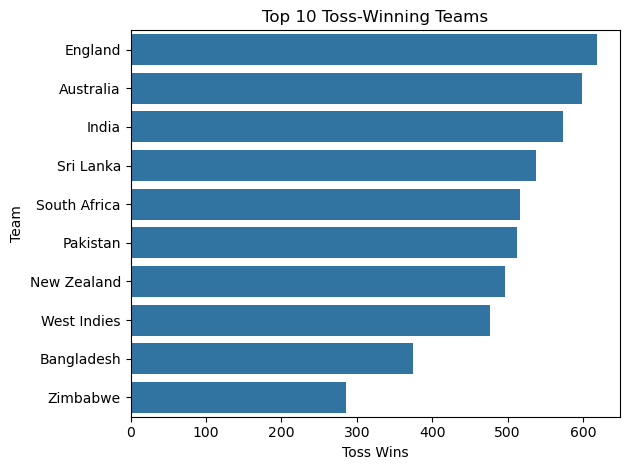

In [ ]:
sns.barplot(data=df_result8, y="toss_winner", x="toss_wins")
plt.title("Top 10 Toss-Winning Teams")
plt.xlabel("Toss Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


### query9: most victorious teams overall

In [ ]:

query9 = """
SELECT winner, COUNT(*) AS total_wins
FROM match_summary
WHERE winner IS NOT NULL AND winner != 'Draw/No result'
GROUP BY winner
ORDER BY total_wins DESC
LIMIT 10;
"""
df_result9= pd.read_sql_query(query9, conn)
df_result9

,winner,total_wins
0,Australia,730
1,India,713
2,England,645
3,South Africa,555
4,New Zealand,483
5,Pakistan,479
6,Sri Lanka,438
7,West Indies,354
8,Bangladesh,263
9,Ireland,174


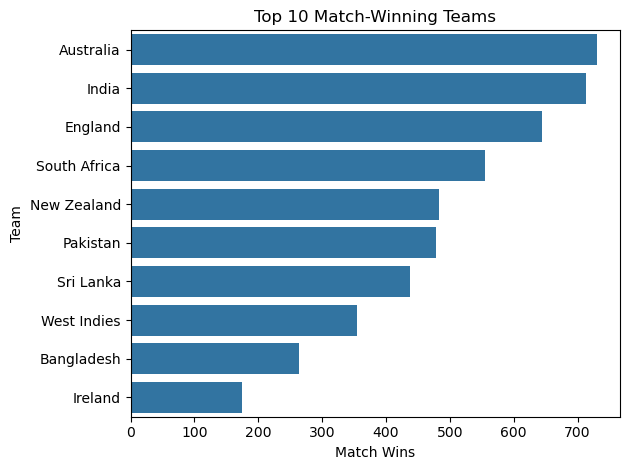

In [ ]:
sns.barplot(data=df_result9, y="winner", x="total_wins")
plt.title("Top 10 Match-Winning Teams")
plt.xlabel("Match Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


### query10: venues hosting most matches

In [ ]:

query10 = """
SELECT venue, COUNT(*) AS matches_hosted
FROM match_summary
GROUP BY venue
ORDER BY matches_hosted DESC
LIMIT 10;
"""
df_result10 = pd.read_sql_query(query10, conn)
df_result10

,venue,matches_hosted
0,Dubai International Cricket Stadium,214
1,Harare Sports Club,191
2,Shere Bangla National Stadium,136
3,Al Amerat Cricket Ground Oman Cricket (Ministr...,129
4,Sheikh Zayed Stadium,116
5,Eden Gardens,103
6,Sharjah Cricket Stadium,100
7,Wankhede Stadium,97
8,Sydney Cricket Ground,94
9,M Chinnaswamy Stadium,91


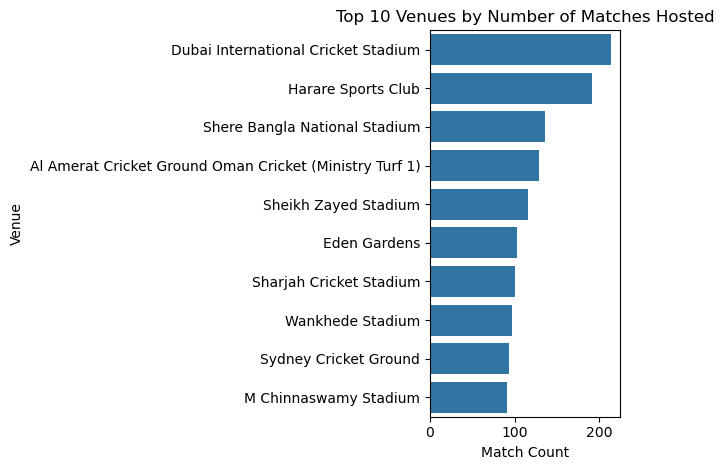

In [ ]:
sns.barplot(data=df_result10, y="venue", x="matches_hosted")
plt.title("Top 10 Venues by Number of Matches Hosted")
plt.xlabel("Match Count")
plt.ylabel("Venue")
plt.tight_layout()
plt.show()

### query11: most sixes by a batter (T20 matches)

In [ ]:

query11 = """
SELECT batter, COUNT(*) AS sixes
FROM t20_matches
WHERE runs_batter = 6
GROUP BY batter
ORDER BY sixes DESC
LIMIT 10;
"""
df_result11 = pd.read_sql_query(query11, conn)
df_result11

,batter,sixes
0,RG Sharma,196
1,MJ Guptill,173
2,JC Buttler,160
3,SA Yadav,142
4,N Pooran,141
5,GJ Maxwell,132
6,Waseem Muhammad,131
7,DA Miller,130
8,CH Gayle,128
9,E Lewis,125


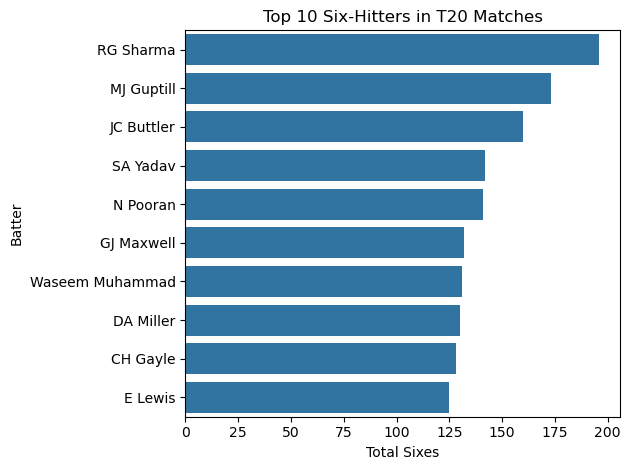

In [ ]:
sns.barplot(data=df_result11, y="batter", x="sixes")
plt.title("Top 10 Six-Hitters in T20 Matches")
plt.xlabel("Total Sixes")
plt.ylabel("Batter")
plt.tight_layout()
plt.show()


### query12: most fours by a batter (ODI matches)

In [ ]:

query12 = """
SELECT batter, COUNT(*) AS fours
FROM odi_matches
WHERE runs_batter = 4
GROUP BY batter
ORDER BY fours DESC
LIMIT 10;
"""
df_result12 = pd.read_sql_query(query12, conn)
df_result12

,batter,fours
0,V Kohli,1315
1,KC Sangakkara,1120
2,RG Sharma,1024
3,TM Dilshan,1022
4,Tamim Iqbal,841
5,S Dhawan,838
6,AB de Villiers,825
7,HM Amla,796
8,MS Dhoni,787
9,SR Tendulkar,774


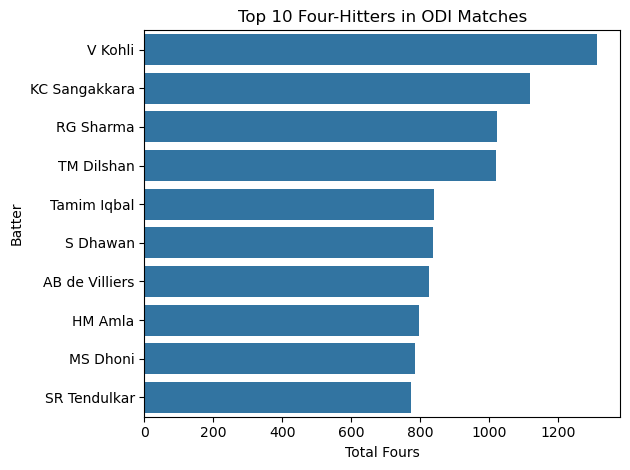

In [ ]:
sns.barplot(data=df_result12, y="batter", x="fours")
plt.title("Top 10 Four-Hitters in ODI Matches")
plt.xlabel("Total Fours")
plt.ylabel("Batter")
plt.tight_layout()
plt.show()


### query13: bowlers with most dot balls (IPL)

In [ ]:

query13 = """
SELECT bowler, COUNT(*) AS dot_balls
FROM ipl_matches
WHERE total_runs = 0
GROUP BY bowler
ORDER BY dot_balls DESC
LIMIT 10;
"""
df_result13 = pd.read_sql_query(query13, conn)
df_result13

,bowler,dot_balls
0,B Kumar,1748
1,SP Narine,1653
2,R Ashwin,1606
3,JJ Bumrah,1353
4,PP Chawla,1325
5,RA Jadeja,1292
6,YS Chahal,1266
7,Harbhajan Singh,1263
8,UT Yadav,1186
9,A Mishra,1185


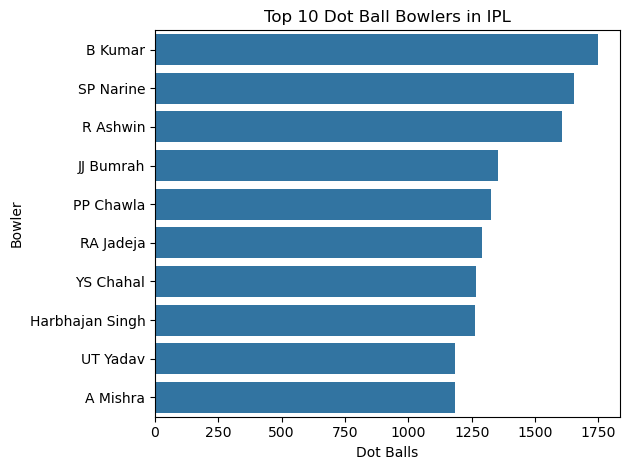

In [ ]:
sns.barplot(data=df_result13, y="bowler", x="dot_balls")
plt.title("Top 10 Dot Ball Bowlers in IPL")
plt.xlabel("Dot Balls")
plt.ylabel("Bowler")
plt.tight_layout()
plt.show()


### query14: players with most dismissals (all match types)

In [ ]:

query14 = """
SELECT player_out, COUNT(*) AS dismissals
FROM (
    SELECT player_out FROM test_matches
    UNION ALL
    SELECT player_out FROM odi_matches
    UNION ALL
    SELECT player_out FROM t20_matches
    UNION ALL
    SELECT player_out FROM ipl_matches
)
WHERE player_out IS NOT NULL
GROUP BY player_out
ORDER BY dismissals DESC
LIMIT 10;
"""
df_result14 = pd.read_sql_query(query14, conn)
df_result14

,player_out,dismissals
0,V Kohli,742
1,RG Sharma,702
2,DA Warner,609
3,AB de Villiers,525
4,MS Dhoni,509
5,KC Sangakkara,500
6,DPMD Jayawardene,481
7,BB McCullum,477
8,CH Gayle,470
9,S Dhawan,465


### query15: total runs scored by each team (ODI)

In [ ]:

query15 = """
SELECT team, SUM(total_runs) AS total_team_runs
FROM odi_matches
GROUP BY team
ORDER BY total_team_runs DESC
LIMIT 10;
"""
df_result15 = pd.read_sql_query(query15, conn)
df_result15

,team,total_team_runs
0,India,148290
1,Australia,137661
2,England,129540
3,Sri Lanka,119723
4,South Africa,116734
5,Pakistan,112022
6,New Zealand,108042
7,West Indies,98303
8,Bangladesh,74513
9,Zimbabwe,58740


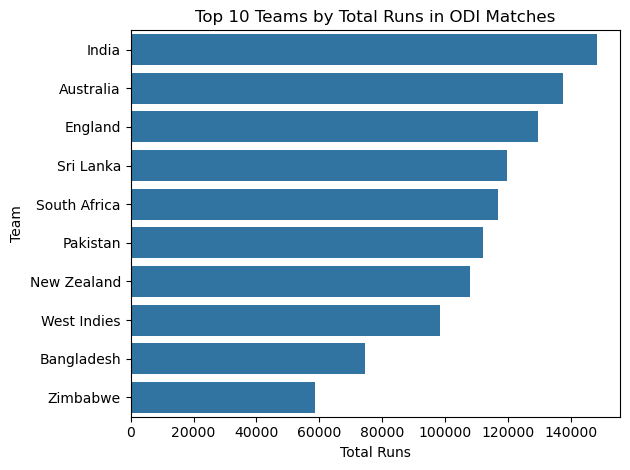

In [ ]:
sns.barplot(data=df_result15, y="team", x="total_team_runs")
plt.title("Top 10 Teams by Total Runs in ODI Matches")
plt.xlabel("Total Runs")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


### query16: team that won most tosses and also won the match (ODI)

In [ ]:

query16 = """
SELECT toss_winner, toss_decision, COUNT(*) AS toss_match_wins
FROM match_summary
WHERE toss_winner = winner
GROUP BY toss_winner, toss_decision
ORDER BY toss_match_wins DESC;
"""
df_result16 = pd.read_sql_query(query16, conn)
df_result16

,toss_winner,toss_decision,toss_match_wins
0,Australia,bat,217
1,England,field,178
2,India,bat,178
3,India,field,173
4,Australia,field,157
...,...,...,...
196,Philippines,bat,1
197,Royal Challengers Bengaluru,bat,1
198,Serbia,bat,1
199,Seychelles,field,1


### query17: number of matches decided by wickets

In [ ]:

query17 = """
SELECT COUNT(*) AS wickets_victories
FROM match_summary
WHERE margin_type = 'wickets';
"""
df_result17 = pd.read_sql_query(query17, conn)
df_result17

,wickets_victories
0,4370


### query18: number of matches decided by runs

In [ ]:

query18 = """
SELECT COUNT(*) AS runs_victories
FROM match_summary
WHERE margin_type = 'runs';
"""
df_result18 = pd.read_sql_query(query18, conn)
df_result18

,runs_victories
0,4517


### query19: total boundaries (4s and 6s) in IPL

In [ ]:

query19 = """
SELECT
    SUM(CASE WHEN runs_batter = 4 THEN 1 ELSE 0 END) AS total_fours,
    SUM(CASE WHEN runs_batter = 6 THEN 1 ELSE 0 END) AS total_sixes
FROM ipl_matches;

"""
df_result19 = pd.read_sql_query(query19, conn)
df_result19

,total_fours,total_sixes
0,32113,14353


### query20: batters with most 50+ scores (All match types)

In [ ]:

query20 = """
SELECT batter, COUNT(*) AS fifties_or_more
FROM (
    SELECT batter, date, SUM(runs_batter) AS total_runs
    FROM (
        SELECT batter, date, runs_batter FROM test_matches
        UNION ALL
        SELECT batter, date, runs_batter FROM odi_matches
        UNION ALL
        SELECT batter, date, runs_batter FROM t20_matches
        UNION ALL
        SELECT batter, date, runs_batter FROM ipl_matches
    )
    GROUP BY batter, date
    HAVING total_runs >= 50
)
GROUP BY batter
ORDER BY fifties_or_more DESC
LIMIT 10;

"""
df_result20 = pd.read_sql_query(query20, conn)
df_result20

,batter,fifties_or_more
0,V Kohli,296
1,DA Warner,213
2,RG Sharma,208
3,AB de Villiers,200
4,KC Sangakkara,177
5,KS Williamson,165
6,JE Root,164
7,HM Amla,146
8,MS Dhoni,145
9,SPD Smith,136


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



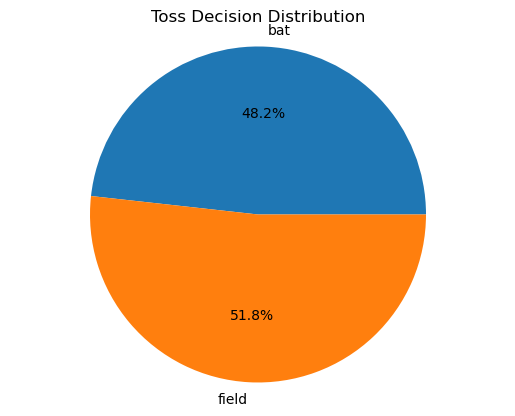

In [ ]:
# 2. Toss decision pie chart

query = """
SELECT toss_decision, COUNT(*) AS count
FROM match_summary
GROUP BY toss_decision;
"""
df_toss = pd.read_sql_query(query, conn)

plt.pie(df_toss['count'], labels=df_toss['toss_decision'], autopct='%1.1f%%')
plt.title("Toss Decision Distribution")
plt.axis("equal")
plt.show()


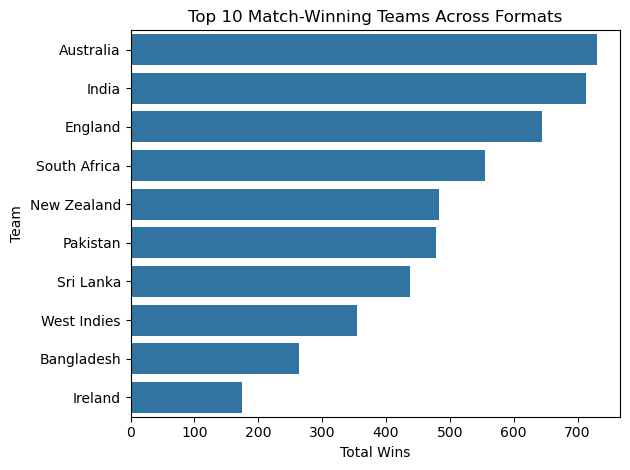

In [ ]:
# 3. run SQL to get win counts

query3 = """
SELECT winner, COUNT(*) AS total_wins
FROM match_summary
WHERE winner IS NOT NULL AND winner != 'Draw/No result'
GROUP BY winner
ORDER BY total_wins DESC
LIMIT 10;
"""

df_top_winners = pd.read_sql_query(query3, conn)
df_top_winners


sns.barplot(data=df_top_winners, y="winner", x="total_wins")
plt.title("Top 10 Match-Winning Teams Across Formats")
plt.xlabel("Total Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


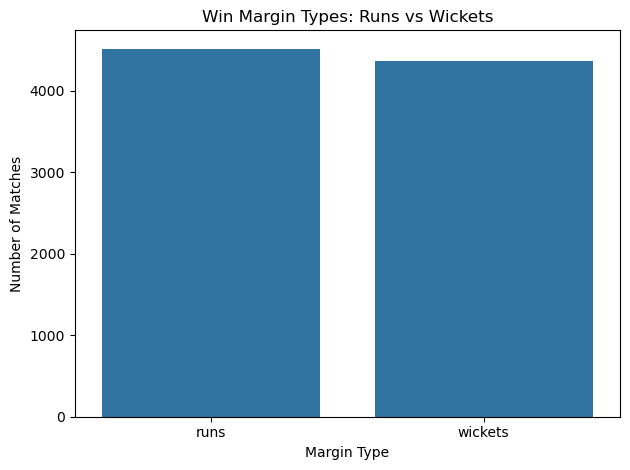

In [ ]:
# 4. Win margin type (runs vs wickets)

query4 = """
SELECT margin_type, COUNT(*) AS count
FROM match_summary
WHERE margin_type IS NOT NULL
GROUP BY margin_type;
"""

df_margin = pd.read_sql_query(query4, conn)
df_margin

sns.barplot(data=df_margin, x="margin_type", y="count")
plt.title("Win Margin Types: Runs vs Wickets")
plt.xlabel("Margin Type")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()


In [ ]:
!pip install pandoc

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34821 sha256=654d9979e42f35e83cec991b4d7dd1d1c004e43c2b60dcece5a569d24da16631
  Stored in directory: c:\users\ishaa\appdata\local\pip\cache\wheels\9c\2f\9f\b1aac8c3e74b4ee327dc8c6eac5128996f9eadf586e2c0ba67
Successfully built pandoc
